# Mining Frequent Itemsets

First, let's import the packages and dependencies that will be used later.

In [59]:
# Standard library imports
import re
from typing import Dict
import warnings

# Related third party imports
import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import plotly.express as px
import requests
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import squarify

# set the default style for the plots and supress warnings
sns.set_style("whitegrid")
sns.set_palette("colorblind")
warnings.filterwarnings("ignore")

## 1. Data Preprocessing

This dataset contains a sample of roughly 10 thousand Tweets that contain two or more food or drink emojis. We will represent the emojis in these tweets as a collection of itemsets and calulate their similarity. 

In [2]:
# read the local file that contains sampled tweets
tweets_df = pd.read_csv(
    "assets/food_drink_emoji_tweets.txt", sep="\t", header=None
).rename(columns={0: "text"})

print(tweets_df.shape)
tweets_df.head()

(9958, 1)


,text
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...
3,@britch_x Hubby's friend bought us Wendy's-che...
4,RT @DAILYPUPPlES: Workout partner ☕🍌😍 https://...


Notice that every line of this data is a tweet. There are a few more features that we can extract from this dataset that may give us context into the dataset. 

In [37]:
tweets_unique_emojis = set()
for text in tweets_df['text']:
    emojis = emoji.emoji_list(text)
    for emoji_data in emojis:
        tweets_unique_emojis.add(emoji_data['emoji'])

print(tweets_unique_emojis)

{'💪🏽', '♠️', '🛶', '🔮', '👍🏽', '👏🏾', '🚲', '🤹🏾\u200d♀️', '👩\u200d👩\u200d👧\u200d👦', '🐫', '🤸🏾\u200d♀️', '🥢', '🎇', '🐂', '⤵️', '♣️', '⛈', '🇬🇧', '☄', '😴', '🇨🇮', '🗺', '🦔', '🧘\u200d♂️', '👩🏻\u200d🍳', '👩\u200d🦰', '🕑', '🌤️', '🤟🏼', '👋🏻', '💆', '👱', '1⃣', '📷', '🍻', '🧧', '🍆', '⚱️', '🔹', '👶🏻', '🌺', '📦', '👉🏻', '🔓', '🤟', '🐣', '🛳', '🇧🇪', '🌹', '🙄', '🧸', '🕥', '🈹', '⛪', '🤮', '🌨', '🥝', '⁉️', '🤛🏼', '⚧', '🤠', '✊🏾', '🌪️', '✏️', '🏜', '🐤', '🐖', '🏊🏼\u200d♀️', '🤦', '🧙🏼\u200d♀️', '🤤', '🥯', '🏃🏽\u200d♂️', '♨️', '👎🏽', '🇱🇸', '🅾️', '〰', '👈🏻', '🚬', '🐉', '💁🏽', '✈', '🧣', '🥞', '📵', '🏔️', '🌧', '📘', '🥡', '🐯', '🔈', '😶', '🚰', '🤙', '📜', '🏖', '🚦', '🏰', '🥜', '🤢', '🎳', '🥖', '🛴', '🥘', '🌚', '☃️', '👧🏾', '🌼', '🇹🇹', '👨\u200d👩\u200d👦\u200d👦', '🔉', '🦀', '🎃', '🤳', '📺', '🐷', '👂', '➡️', '🤦🏻\u200d♀️', '🐡', '😔', '🔛', '🙅\u200d♀️', '🥅', '🇬🇾', '🖖🏼', '🤥', '🇮🇸', '🥪', '😅', '❣', '🧞\u200d♀️', '🔼', '▪', '🏋🏻\u200d♂️', '👳', '💹', '🏊\u200d♀️', '🍼', '🗓️', '🌳', '🔭', '🙇🏼\u200d♂️', '🤵🏽', '🎧', '🧚🏽\u200d♀️', '💁🏻\u200d♀️', '🎒', '🙆🏻\u200d♀️', '🔆', '🔐', '👠', '🤗', '💣',

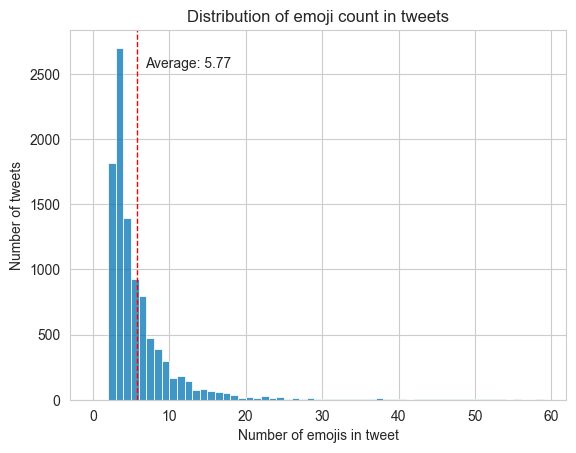

In [3]:
# Count emojis per tweet (including diuplicates)
tweets_df["emoji_count"] = tweets_df["text"].apply(emoji.emoji_count)

# Calculate the central tendancy stats
average_emojis = tweets_df["emoji_count"].mean()
median_emoji = tweets_df["emoji_count"].median()

sns.histplot(tweets_df["emoji_count"], bins=range(0, 60))
plt.xlabel("Number of emojis in tweet")
plt.ylabel("Number of tweets")
plt.title("Distribution of emoji count in tweets")

# Add a vertical line at the average number of emojis
plt.axvline(average_emojis, color="r", linestyle="dashed", linewidth=1)

# Add a text annotation
plt.annotate(
    "Average: {:.2f}".format(average_emojis),
    xy=(average_emojis, 0),
    xytext=(average_emojis + 1, 2550),
)

plt.show()

In addition, it would be ideal to organize the emojis witnessed into semantic categories. One consistent way of doing so is by pulling the unicode categories from unicode.org. The code below does so. 

In [4]:
def fetch_emoji_data():
    # Use a context manager for the request
    with requests.get(
        "https://unicode.org/Public/emoji/13.1/emoji-test.txt"
    ) as response:
        lines = response.text.split("\n")

    current_group = current_subgroup = None
    emoji_categories = {}

    for line in lines:
        if line.startswith("# group:"):
            current_group = line.split(": ")[1]
        elif line.startswith("# subgroup:"):
            current_subgroup = line.split(": ")[1]
        elif line and not line.startswith("#"):
            emoji_str = re.findall(r"#\s(.+)", line.split(";")[1])[0].split()[0].strip()
            emoji_categories[emoji_str] = {
                "group": current_group,
                "subgroup": current_subgroup,
            }

    return emoji_categories

emoji_categories = fetch_emoji_data()

In [5]:
# store all possible emojis in a set that will remain constant
EMOJI_SET = set(emoji_categories.keys())

# explore categories
print(emoji_categories[emoji.emojize(":grinning_face_with_big_eyes:")])
print(emoji_categories["😃"]) # equivalent to line above

{'group': 'Smileys & Emotion', 'subgroup': 'face-smiling'}
{'group': 'Smileys & Emotion', 'subgroup': 'face-smiling'}


In [6]:
# store all emojis, categories and subgroups in a dataframe for convenience
emoji_df = pd.DataFrame.from_dict(emoji_categories, orient="index").reset_index()
emoji_df.columns = ["emoji", "category", "subgroup"]
emoji_df.sample(5)

,emoji,category,subgroup
2388,🤸🏾‍♀️,People & Body,person-sport
2574,👭🏾,People & Body,family
3091,🐈,Animals & Nature,animal-mammal
834,🙇🏼‍♂,People & Body,person-gesture
1317,🕵🏾‍♀,People & Body,person-role


In [45]:
tweets_emoji_categories_df = emoji_df[emoji_df["emoji"].isin(tweets_unique_emojis)]
tweets_emoji_categories_df.sample(5)

,emoji,category,subgroup
221,✌🏻,People & Body,hand-fingers-partial
4174,⚜️,Symbols,other-symbol
3235,🍐,Food & Drink,food-fruit
3653,🏀,Activities,sport
4007,⚰️,Objects,other-object


In [50]:
def extract_uniq_emojis(text: str, emoji_set: set) -> np.array:
    """Extracts unique emojis from the text."""
    return np.unique([chr for chr in text if chr in emoji_set])


def extract_uniq_emoji_categories(
    text: str, emoji_set: set, emoji_categories: Dict[str, Dict[str, str]]
) -> np.array:
    """Extracts unique emoji categories from the text."""
    return np.unique(
        [emoji_categories[chr]["group"] for chr in text if chr in emoji_set]
    )


def extract_uniq_emojis_subgroups(
    text: str, emoji_set: set, emoji_categories: Dict[str, Dict[str, str]]
) -> np.array:
    """Extracts unique emoji subgroups from the text."""
    return np.unique(
        [emoji_categories[chr]["subgroup"] for chr in text if chr in emoji_set]
    )

In [52]:
tweets_df["emojis"] = tweets_df["text"].apply(lambda x: extract_uniq_emojis(x, EMOJI_SET))
tweets_df["emoji_categories"] = tweets_df.text.apply(
    lambda x: extract_uniq_emoji_categories(x, EMOJI_SET, emoji_categories)
)
tweets_df["emoji_subgroups"] = tweets_df.text.apply(
    lambda x: extract_uniq_emojis_subgroups(x, EMOJI_SET, emoji_categories)
)

tweets_df.head()

,text,emoji_count,emoji_categories,emoji_subgroups,emojis
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...,4,[Food & Drink],"[food-fruit, food-prepared]","[🌯, 🍒, 🍔, 🍗]"
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...,7,[Food & Drink],[food-fruit],"[🍇, 🍈, 🍉, 🍊, 🍍, 🍓]"
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...,24,"[Food & Drink, Objects, People & Body, Symbols]","[clothing, drink, hand-single-finger, keycap, ...","[🍸, 🎧, 👉, 👒, 💃, 🔟, 🕺, 🥃]"
3,@britch_x Hubby's friend bought us Wendy's-che...,2,[Food & Drink],[food-prepared],"[🍔, 🍟]"
4,RT @DAILYPUPPlES: Workout partner ☕🍌😍 https://...,3,"[Food & Drink, Smileys & Emotion]","[drink, face-affection, food-fruit]","[☕, 🍌, 😍]"


/usr/local/lib/python3.10/site-packages/squarify/__init__.py:231: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



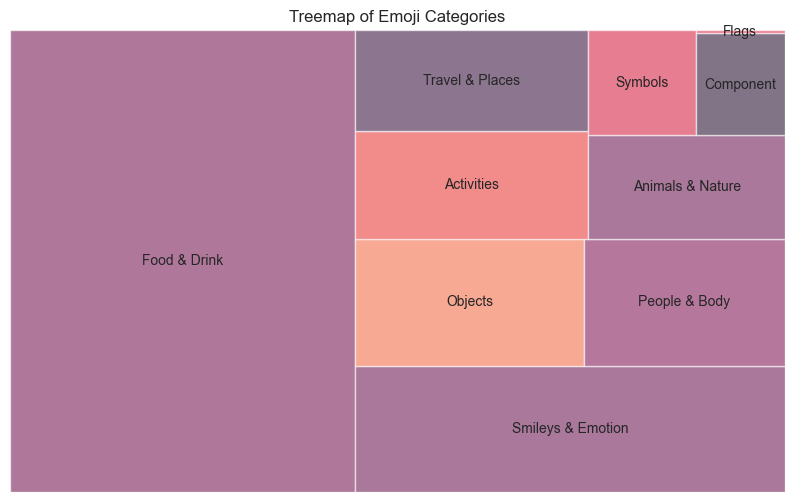

In [53]:
# Flatten the list of categories and calculate the counts
category_counts = tweets_df["emoji_categories"].explode().value_counts()
subcategories_counts = tweets_df["emoji_subgroups"].explode().value_counts()

# Create a treemap
fig = plt.figure(figsize=(10, 6))
squarify.plot(sizes=category_counts.values, label=category_counts.index, alpha=0.6)
plt.title("Treemap of Emoji Categories")
plt.axis("off")
plt.show()

In [54]:

fig = px.sunburst(
    tweets_emoji_categories_df, path=["category", "subgroup"], color="subgroup"
)
fig.show()

In [49]:
tweets_df

,text,emoji_count,emoji_categories,emoji_subgroups
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...,4,[Food & Drink],"[food-fruit, food-prepared]"
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...,7,[Food & Drink],[food-fruit]
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...,24,"[Food & Drink, Objects, People & Body, Symbols]","[clothing, drink, hand-single-finger, keycap, ..."
3,@britch_x Hubby's friend bought us Wendy's-che...,2,[Food & Drink],[food-prepared]
4,RT @DAILYPUPPlES: Workout partner ☕🍌😍 https://...,3,"[Food & Drink, Smileys & Emotion]","[drink, face-affection, food-fruit]"
...,...,...,...,...
9953,#1stTest Brilliant Tension #England need 2wks ...,6,"[Activities, Food & Drink, People & Body, Smil...","[drink, face-smiling, hands, sport]"
9954,"RT @Thabang92416252: ""@PinexAndApplex: 🍍🍏 @Emt...",3,"[Food & Drink, Travel & Places]","[food-fruit, sky & weather]"
9955,@nuttysteph84 Steph!! 😭😭 🥓☕️🍳🤦🏼‍♂️❤️x,7,"[Component, Food & Drink, People & Body, Smile...","[drink, emotion, face-concerned, food-prepared..."
9956,I'm heading to a wedding. Weekend session afoo...,6,"[Activities, Food & Drink, Travel & Places]","[drink, event, place-building]"


In [56]:
mlb = MultiLabelBinarizer()
emoji_matrix = pd.DataFrame(
    data=mlb.fit_transform(tweets_df.emojis),
    index=tweets_df.index,
    columns=mlb.classes_,
)
emoji_matrix.head()

,©,®,‼,⁉,™,ℹ,↖,↗,↘,↙,...,🧣,🧥,🧦,🧧,🧮,🧳,🧶,🧸,🧹,🧺
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Summary Statistics 

In [57]:
emoji_length = emoji_matrix.sum(axis=1)
tweets_df.join(emoji_length.rename("emoji_count"))

ValueError: columns overlap but no suffix specified: Index(['emoji_count'], dtype='object')

In [ ]:
tweets_df.join(emoji_length.rename("emoji_count"))

In [ ]:
emoji_length_distribution = (
    emoji_length.value_counts()
    .rename_axis(index="emoji_length")
    .rename("freq")
    .reset_index()
)
emoji_length_distribution.head()

In [ ]:
_, ax = plt.subplots()
ax.plot(emoji_length_distribution.emoji_length, emoji_length_distribution.freq, "o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("#emojis in a tweet")
ax.set_ylabel("frequency of tweets")


Finding the most popular emojis

In [ ]:
emoji_matrix.sum(axis=0).sort_values(ascending=False).head(10)

Finding frequent itemsets

In [ ]:
frequent_itemsets = apriori(emoji_matrix, min_support=0.005, use_colnames=True)
frequent_itemsets

In [ ]:
def emoji_frequent_itemsets(emoji_matrix, min_support=0.005, k=3):
    frequent_itemsets = apriori(
        emoji_matrix, min_support=min_support, use_colnames=True
    )
    return frequent_itemsets[frequent_itemsets["itemsets"].apply(lambda x: len(x)) == k]

In [ ]:
emoji_frequent_3itemsets = emoji_frequent_itemsets(emoji_matrix, min_support=0.005, k=3)
# You can uncomment the following line to view the obtained frequent itemsets.
emoji_frequent_3itemsets

In [ ]:
emoji_frequent_4itemsets = emoji_frequent_itemsets(emoji_matrix, min_support=0.005, k=4)
emoji_frequent_4itemsets

People have developed various measurements of the interestingness of patterns. Most of them split the itemset into an antecedent item(set) and a consequent item(set), and then measure the correlation between the antecedent and the consequent.

In [ ]:
interestingness_measurements = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=0,
)

interestingness_measurements.sort_values("support", ascending=False).head(10)

### Calculating the full mutual information

Full mutual information is defined as:

$$I(X;Y)=\sum_{x\in\mathcal{X}}\sum_{y\in\mathcal{Y}} P(X=x, Y=y)\log_2\frac{P(X=x,Y=y)}{P(X=x)P(Y=y)}.$$

Note that the logorithm requires that the joint probability $P(X=x, Y=y) > 0$, which does not hold for some $(x, y)$. However, since we know that when $P(X=x, Y=y) = 0$, it would not contribute to the sum, you may assume $P(X=x, Y=y)\log_2\frac{P(X=x,Y=y)}{P(X=x)P(P=y)} = 0$ in that case.

$x$, $y$ are possible values of $X$ and $Y$; in the case of appearance or absence of an item, 1 or 0. Therefore, we need to consider all possible combinations of $x$ and $y$, that is, $(X=1, Y=1)$, $(X=1, Y=0)$, $(X=0, Y=1)$, $(X=0, Y=0)$.

In [ ]:
def calculate_sum(px: float, py: float, pxy: float) -> float:
    """
    Calculate the sum for a given combination of px, py, and pxy.

    Parameters:
    px (float): The probability of x.
    py (float): The probability of y.
    pxy (float): The joint probability of x and y.

    Returns:
    float: The calculated sum.
    """
    return 0 if pxy == 0 else np.multiply(pxy, np.log2(pxy / (px * py)))


def mi(antecedent_support: float, consequent_support: float, support: float) -> float:
    """
    Calculate the mutual information.

    Parameters:
    antecedent_support (float): The support of the antecedent.
    consequent_support (float): The support of the consequent.
    support (float): The joint support of the antecedent and consequent.

    Returns:
    float: The mutual information.
    """
    px1 = antecedent_support
    px0 = 1 - antecedent_support
    py1 = consequent_support
    py0 = 1 - consequent_support

    px1y1 = support
    px1y0 = px1 - px1y1
    px0y1 = py1 - px1y1
    px0y0 = 1 - px1 - py1 + px1y1

    px1y1_sum = calculate_sum(px1, py1, px1y1)
    px1y0_sum = calculate_sum(px1, py0, px1y0)
    px0y1_sum = calculate_sum(px0, py1, px0y1)
    px0y0_sum = calculate_sum(px0, py0, px0y0)

    return px1y1_sum + px1y0_sum + px0y1_sum + px0y0_sum

With the `mi` function, we can now compute the mutual information for each (antecedent -> consequent) pair and attach it to the data frame. 

In [ ]:
interestingness_measurements["mi"] = interestingness_measurements.apply(
    lambda pair: mi(
        pair["antecedent support"], pair["consequent support"], pair["support"]
    ),
    axis=1,
)
interestingness_measurements.sort_values("mi", ascending=False).head(n=5)

## Item Similarity

In [ ]:
def jaccard_similarity(set_a, set_b):
    union = set_a.union(set_b)
    intersection = set_a.intersection(set_b)

    return len(intersection) / len(union)

In [ ]:
tweets_df

In [ ]:
tweets_df.loc[0].emojis